In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rlxutils import subplots
import pandas as pd
import sys
sys.path.append("..")
import torch
from torch import nn

from lib import data
from lib import sar
from lib import io

from torch import nn  
from loguru import logger
from lib.datamodules.components import scatterdataset
from lib.datamodules import scatterdatamodule
from lib.models import scattermodel
from omegaconf import OmegaConf
import hydra
import pprint
from progressbar import progressbar as pbar
from importlib import reload
reload(scatterdataset)
reload(scattermodel)

<module 'lib.models.scattermodel' from '/home/ubuntu/sar-recovery/notebooks/../lib/models/scattermodel.py'>


**Quad-Pol SAR Data Reconstruction from Dual-Pol SAR Mode Based on a Multiscale Feature Aggregation Network**, https://www.mdpi.com/2072-4292/15/17/4182

$$
S=
\begin{bmatrix}
S_{HH} & S_{HV} \\
S_{VH} & S_{VV} \\
\end{bmatrix}
$$

$$
C=
\begin{bmatrix}
\langle |S_{HH}|^2 \rangle & \sqrt{2} \langle S_{HH}S^{*}_{HV} \rangle &  \langle S_{HH}S^{*}_{VV}\rangle \\
\sqrt{2} \langle S_{HV}S^{*}_{HH} \rangle &  2 \langle |S_{HV}|^2 \rangle  & \sqrt{2} \langle S_{HV}S^{*}_{VV} \rangle \\
\langle S_{VV}S^{*}_{HH} \rangle & \sqrt{2} \langle S_{VV}S^{*}_{HV}\rangle & \langle |S_{VV}|^2 \rangle
\end{bmatrix}
$$

## load hydra conf

In [2]:
conf = OmegaConf.load("../configs/scatter2coherence.yaml")
pprint.pp(OmegaConf.to_container(conf))

{'dataloader': {'_target_': 'lib.datamodules.scatterdatamodule.ScatterCoherencePatchesDataModule',
                'base_path': '/home/rlx/data/sar-recovery',
                'date_train': 20100520,
                'date_test': 20120720,
                'date_val': 20120720,
                'scatter_elems': ['Shh', 'Shv'],
                'coherence_elems': ['Svv2'],
                'patch_size': 60,
                'avg_window_size': 5,
                'splitmask_fn_src': 'lambda h, w: '
                                    'data.cv_splitpixels_spatial(h, w, '
                                    'pixels_train = 280, pixels_test = 60, '
                                    'pixels_val = 60, angle = np.pi/4)'},
 'model': {'_target_': 'lib.models.scattermodel.Scatter2Coherence',
           'in_channels': 2}}


## instantiate dataloader

In [3]:
dl = hydra.utils.instantiate(conf.dataloader)

2024-04-20 14:04:09.471 | INFO     | lib.datamodules.components.scatterdataset:__init__:44 - loading scatter matrix
2024-04-20 14:04:09.618 | INFO     | lib.datamodules.components.scatterdataset:__init__:47 - computing coherence matrix
2024-04-20 14:04:13.251 | INFO     | lib.datamodules.components.scatterdataset:__init__:58 - scatter   matrix shape is (4402, 1602, 2, 2), retrieving elems [('Shh', [0, 0]), ('Shv', [0, 1])]
2024-04-20 14:04:13.251 | INFO     | lib.datamodules.components.scatterdataset:__init__:59 - coherence matrix shape is (4402, 1602, 3, 3), retrieving elems [('Svv2', (2, 2))]
2024-04-20 14:04:13.254 | INFO     | lib.datamodules.components.scatterdataset:__init__:44 - loading scatter matrix
2024-04-20 14:04:13.403 | INFO     | lib.datamodules.components.scatterdataset:__init__:47 - computing coherence matrix
2024-04-20 14:04:17.082 | INFO     | lib.datamodules.components.scatterdataset:__init__:58 - scatter   matrix shape is (4402, 1602, 2, 2), retrieving elems [('Shh

In [4]:
traindl = dl.train_dataloader()
testdl  = dl.test_dataloader()
valdl   = dl.val_dataloader()

In [5]:
len(traindl), len(testdl), len(valdl)

(84, 18, 18)

## instantiate model

In [6]:
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=5e-5)
nparams = sum([len(p.flatten()) for p in m.parameters() if p.requires_grad])
print (f"number of model parameters {nparams}")

number of model parameters 42528


In [7]:
# set weights and freeze first layer to behave as an average 
layer0 = m.layers[0]
layer0.weight.data = torch.ones_like(layer0.weight.data).type(torch.cfloat)

# bias is zero
layer0.bias.data   = torch.zeros_like(layer0.bias.data).type(torch.cfloat)

for p in layer0.parameters():
    p.requires_grad = False

nparams = sum([len(p.flatten()) for p in m.parameters() if p.requires_grad])
print (f"number of model parameters {nparams}")

number of model parameters 42426


In [8]:
m.layers

Sequential(
  (0): Conv2d(2, 2, kernel_size=(5, 5), stride=(5, 5))
  (1): Conv2d(2, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (2): ComplexActivation()
  (3): ComplexBatchNorm2d()
  (4): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (5): ComplexActivation()
  (6): ComplexBatchNorm2d()
  (7): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (8): ComplexActivation()
  (9): ComplexBatchNorm2d()
  (10): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (11): ComplexActivation()
  (12): ComplexBatchNorm2d()
  (13): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (14): ComplexActivation()
  (15): ComplexBatchNorm2d()
  (16): Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (17): ComplexActivation()
  (18): ComplexBatchNorm2d()
  (19): Conv2d(10, 5, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (20): ComplexActivation()
  (21): ComplexBatchNorm2d()
  (22): Conv2d(5, 1, kernel_size=(3, 3), 

## train loop

In [40]:
dtr = dl.train_dataloader()
complex_rmse_loss_fn = lambda y_true, y_pred: torch.sqrt(torch.mean((y_pred-y_true)*(y_pred-y_true).conj()).real)
complex_mse_loss_fn = lambda y_true, y_pred: torch.mean((y_pred-y_true)*(y_pred-y_true).conj()).real
loss_fn = complex_rmse_loss_fn

In [ ]:
n_epochs = 10000

lossh = []
for epoch in range(n_epochs):
    loss_epoch = []
    for step, batch in enumerate(dtr):
        # extract data from batch
        x = batch['scatter_patch']
        t = batch['avg_coherence_patch'] / 20000

        # run model
        o = m(x)
        o_std = o.std()
        # compute losses (complex mse or rmse)
        loss = loss_fn(t, o)

        # backpropage and update
        loss.backward()
        optimizer.step()

        # cosmetics
        ogt0 = (o.real.detach().numpy()>0).mean()
        tgt0 = (t.real.detach().numpy()>0).mean()
        lossn = loss.detach().cpu().numpy()
        loss_epoch.append(lossn)
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-500:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f} o>0 {ogt0:.3f} t>0 {tgt0:.3f} o.std {o_std:.5f}", end="\r")
        
    print(f"epoch {epoch:3}          loss {np.mean(loss_epoch):.4f}")


(1.0, 2.0)

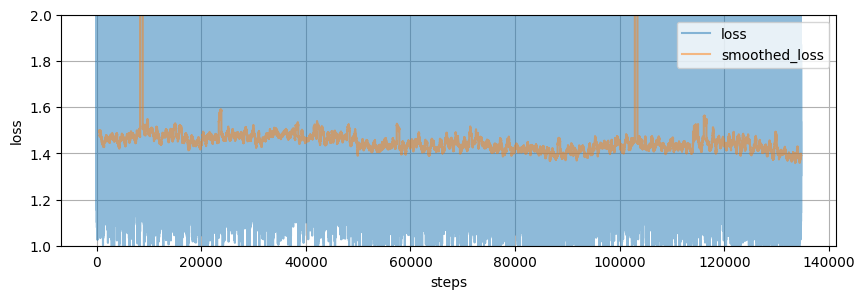

In [23]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(500).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
plt.ylim(1,2)


(1.0, 5.0)

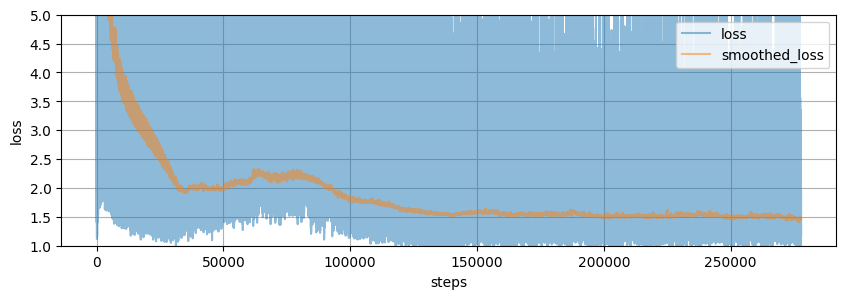

In [12]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(500).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
plt.ylim(1,5)


In [43]:
dataloader = dl.train_dataloader()


In [44]:
def get_predictions(dataloader):
    inputs, targets, predictions = [], [], []
    losses = []
    for batch in pbar(dataloader):
            x = batch['scatter_patch']
            t = batch['avg_coherence_patch'] / 20000
            o = m(x)
            losses.append(loss_fn(t,o))
            for i in range(len(x)):
                inputs.append(x[i])
                targets.append(t[i])
                predictions.append(o[i])
    return torch.stack(inputs), torch.stack(targets), torch.stack(predictions), torch.stack(losses)

In [45]:
tr_inputs, tr_targets, tr_predictions, tr_losses = get_predictions(dl.train_dataloader())
ts_inputs, ts_targets, ts_predictions, ts_losses = get_predictions(dl.test_dataloader())
val_inputs, val_targets, val_predictions, val_losses = get_predictions(dl.val_dataloader())

100% (84 of 84) |########################| Elapsed Time: 0:00:26 Time:  0:00:260002
100% (18 of 18) |########################| Elapsed Time: 0:00:07 Time:  0:00:070000
100% (18 of 18) |########################| Elapsed Time: 0:00:07 Time:  0:00:070000


In [46]:
tr_losses.mean(), ts_losses.mean(), val_losses.mean()

(tensor(1.2659, grad_fn=<MeanBackward0>),
 tensor(5.6187, grad_fn=<MeanBackward0>),
 tensor(5.5599, grad_fn=<MeanBackward0>))

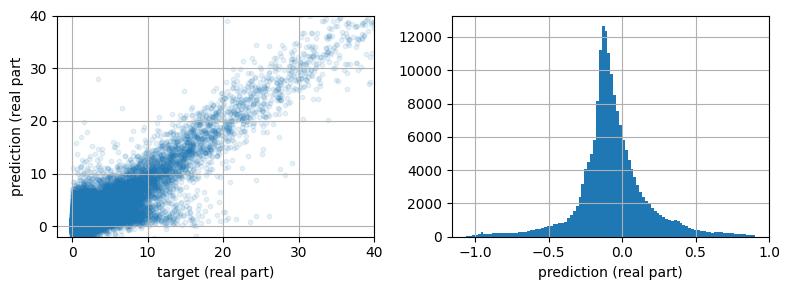

In [47]:
targets, predictions = tr_targets, tr_predictions
for ax,i in subplots(2, usizex=4):
    if i==0:
        _t = targets.detach().numpy().real.flatten()
        _o = predictions.detach().numpy().real.flatten()
        ta,tb = np.percentile(_t, [0,95])
        oa,ob = np.percentile(_o, [1,95])
        plt.scatter(_t, _o, s=10, alpha=.1);
        plt.xlim(-2,40)
        plt.ylim(-2,40)
        plt.grid();
        plt.xlabel("target (real part)")
        plt.ylabel("prediction (real part")
    if i==1:
        _o = predictions.detach().numpy().imag.flatten()
        a,b = np.percentile(_o, [1,99])
        _o = _o[(_o>a)&(_o<b)]
        plt.hist(_o, bins=100);
        plt.grid();
        plt.xlabel("prediction (real part)")